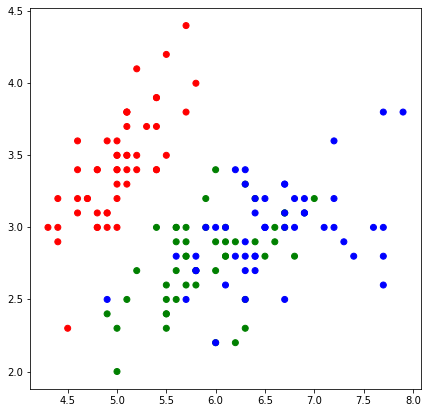

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

<b>1. Модифицировать реализацию KNN из методички так, чтобы больший вес получали наиболее близко расположенные объекты</b>

In [2]:
def e_metrics(x1, x2):
    
    return np.sqrt(np.sum((x2-x1)**2))

def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            #!!ЧЕМ БОЛЬШЕ ДИСТАНЦИЯ ТЕМ ВЕС МЕНЬШЕ!!
            classes[d[1]] += 1 - d[0]
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [3]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.867


In [4]:
k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.867


<b>ВЫВОД: На к = 5 и к = 10 точность одинаковая, хотя без учета дистанции на к = 10 точность падает, что говорит об большей устойчивости модели к переобучению.</b>

Иерархическая кластеризация

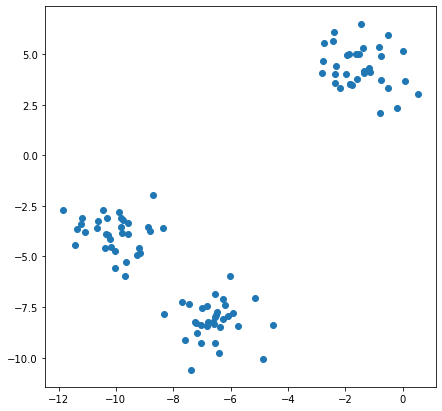

In [5]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)

plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [6]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

def visualize(centroids, classes):
    colors = ['r', 'g', 'b', 'm']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()
    
# определим максимальное количество итераций
max_iterations = 25

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 4

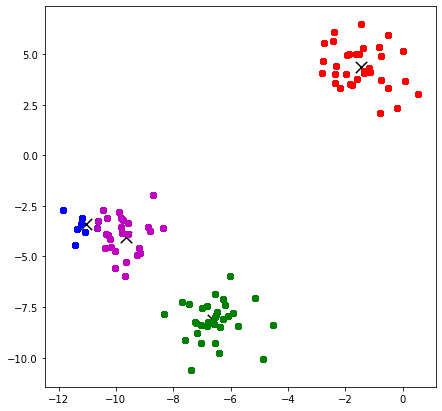

In [7]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

In [8]:
# Average Linkage Distance
# Single Linkage Distance and
# Complete Linkage Distance
def mean_dist(u_clast, v_clast, idis = 'CLD'):

    if idis == 'SLD':
        return min((e_metrics(x, y) for x in u_clast for y in v_clast))
    elif idis == 'CLD':
        return max((e_metrics(x, y) for x in u_clast for y in v_clast))
    else:
        return sum((e_metrics(x, y) for x in u_clast for y in v_clast))/(len(u_clast)*len(v_clast))

def dist_matrix(clusters):
  matrix=np.zeros((len(clusters), len(clusters)))
  for i, u in enumerate(clusters):
    for j, v in enumerate(clusters[i+1:], start=i+1):
      matrix[[i, j], [j, i]]=mean_dist(u, v)
  return matrix

def indexes_to_combine(dist_matrix):
  min_el=dist_matrix[np.triu_indices(dist_matrix.shape[0], 1)].min()
  return np.argwhere(dist_matrix==min_el)[0], min_el

def exclude_clusters(i, j, dist_matrix):
  mask=np.ones(dist_matrix.shape[0], dtype=bool)
  mask[i]=False
  mask[j]=False
  return dist_matrix[mask, :][:, mask]

def merge_clusters(i, j, clusters):
  new_cluster=clusters[i]+clusters[j]
  return new_cluster, [c for k, c in enumerate(clusters) if not k in [i, j]]

def include_cluster(dist_mat, old_clusters, new_cluster):
  new_col=np.array([mean_dist(c, new_cluster) for c in old_clusters])[:, np.newaxis]
  dist_mat=np.concatenate([dist_mat, new_col], axis=1)
  new_row=np.concatenate([new_col.flatten(), [0]])[np.newaxis, :]
  dist_mat=np.concatenate([dist_mat, new_row], axis=0)
  return dist_mat

def hierarchy_clustering(cluster_list):
  cluster_list=cluster_list[:]
  dist_mat=dist_matrix(cluster_list)
  cluster_numbers=list(range(len(cluster_list)))
  z=[]
  new_num=len(cluster_list)
  while len(cluster_list)>1:
    [i, j], min_val=indexes_to_combine(dist_mat)
    dist_mat=exclude_clusters(i, j, dist_mat)
    new_cluster, old_clusters=merge_clusters(i, j, cluster_list)
    dist_mat=include_cluster(dist_mat, old_clusters, new_cluster)
    z.append([cluster_numbers[i], cluster_numbers[j], min_val, len(new_cluster)])
    print([cluster_numbers[i], cluster_numbers[j], min_val, len(new_cluster)])
    cluster_list=old_clusters+[new_cluster]
    cluster_numbers=[n for k, n in enumerate(cluster_numbers) if not k in [i, j]]+[new_num]
    new_num+=1
  return z

In [9]:
cluster_keys=list(clusters.keys())
cluster_data=[clusters[k] for k in cluster_keys]

dist_matrix(cluster_data)

array([[ 0.        , 18.0863922 , 15.06463051, 15.01507892],
       [18.0863922 ,  0.        , 10.12450811,  9.19921689],
       [15.06463051, 10.12450811,  0.        ,  3.9168296 ],
       [15.01507892,  9.19921689,  3.9168296 ,  0.        ]])

In [10]:
Z=hierarchy_clustering(cluster_data)

[2, 3, 3.916829600863291, 815]
[1, 4, 10.124508111718242, 1650]
[0, 5, 18.086392197542647, 2500]


{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5]],
 'dcoord': [[0.0, 3.916829600863291, 3.916829600863291, 0.0],
  [0.0, 10.124508111718242, 10.124508111718242, 3.916829600863291],
  [0.0, 18.086392197542647, 18.086392197542647, 10.124508111718242]],
 'ivl': ['r', 'g', 'b', 'm'],
 'leaves': [0, 1, 2, 3],
 'color_list': ['C1', 'C1', 'C0']}

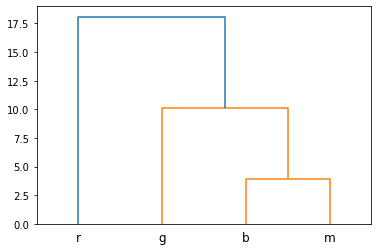

In [11]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
hierarchy.dendrogram(Z, labels= ['r', 'g', 'b', 'm'])